In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# https://users.utcluj.ro/~igiosan/Resources/PI/L5/PI-L5e.pdf

def neighborhood(i, j):
    upper = (i - 1, j)
    left = (i, j - 1)
    lower = (i + 1, j)
    right = (i, j + 1)
    return upper, left, lower, right

def label_bfs_dfs_and_clusterize(matrix, bfs=True):
    height, width = len(matrix), len(matrix[0])
    label = 0
    labels = np.zeros((height, width))
    clusters = {}
    for i in range(height):
        for j in range(width):
            if (
                matrix[i][j] == 1
                and labels[i][j] == 0
            ):
                label += 1
                Q = []
                labels[i][j] = label
                if label not in clusters:
                  clusters[label] = []
                clusters[label].append((i,j))
                Q.append((i, j))
                while Q:
                    q = Q.pop(0) if bfs else Q.pop()
                    for neighbor in neighborhood(q[0], q[1]):
                        x, y = neighbor
                        if (
                            0 <= x < height
                            and 0 <= y < width
                            and matrix[x][y] == 1
                            and labels[x][y] == 0
                        ):
                            labels[x][y] = label
                            if label not in clusters:
                              clusters[label] = []
                            clusters[label].append((x,y))
                            Q.append(neighbor)
    return labels, label, clusters


In [3]:
class ClassicSitePercolation:
  def __init__(self, N, p):
    self.N = N
    self.p = p
    self.data = (np.random.random((N,N)) < p) * 1

  def find_clusters(self):
    self.labels, self.label, \
      self.clusters = label_bfs_dfs_and_clusterize(self.data, bfs=False)

  def visualize(self):
    plt.imshow(self.labels, cmap='hot')
    plt.colorbar()

  def find_percolating_cluster(self):
    cluster = None
    filter_n = dict(filter(lambda item: len(item[1]) >= self.N,
                                self.clusters.items()))
    for cluster_ in filter_n:
      upper_row_candidates = [index for index in filter_n[cluster_]
                                               if index[0] == 0]
      lower_row_candidates = [index for index in filter_n[cluster_]
                                               if index[0] == self.N-1]
      if upper_row_candidates and lower_row_candidates:
        cluster = cluster_
    return cluster

  def show_specific_cluster(self, n):
    assert n <= self.label
    plt.imshow(self.labels == n, cmap='hot')



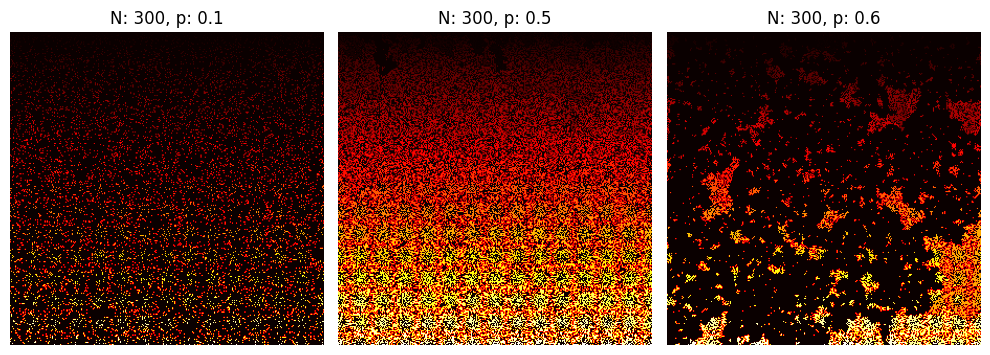

In [4]:
def visualize_multiple_percolations(sizes, probabilities):
    num_plots = len(sizes)
    fig, axs = plt.subplots(1, num_plots, figsize=(10, 5))

    for ax, size, prob in zip(axs, sizes, probabilities):
        percolation = ClassicSitePercolation(size, prob)
        percolation.find_clusters()
        ax.imshow(percolation.labels, cmap='hot')
        ax.set_title(f"N: {size}, p: {prob}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

sizes = [300, 300, 300]
probabilities = [0.1, 0.5, 0.6]
visualize_multiple_percolations(sizes, probabilities)


Number of clusters: 57510


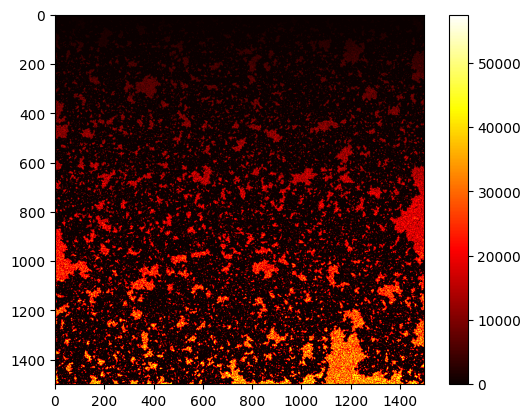

In [5]:
c = ClassicSitePercolation(1500, 0.6)
c.find_clusters()
print("Number of clusters:", c.label)
c.visualize()

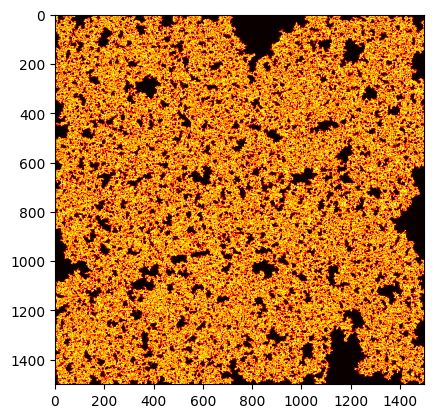

In [6]:
x = c.find_percolating_cluster()
if x:
    c.show_specific_cluster(x)

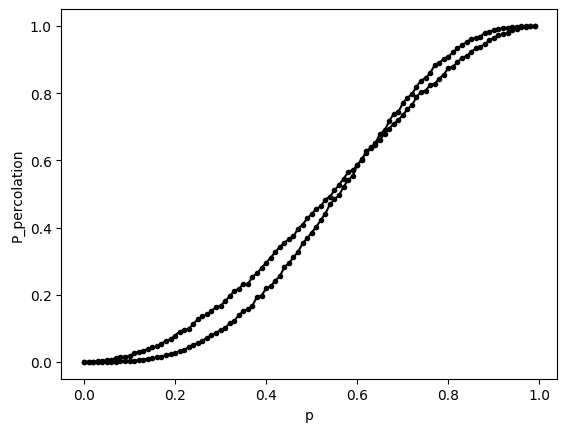

In [7]:
res = []
for n in [2,3]:
    iterations = 10000
    p_vec = np.arange(0, 1, 0.01)

    percolation_prob = np.zeros(len(p_vec))

    for p_indx, p in enumerate(p_vec):
        counter = 0
        for _ in range(iterations):
            c = ClassicSitePercolation(n, p)
            c.find_clusters()
            x = c.find_percolating_cluster()
            if x:
                counter += 1
        percolation_prob[p_indx] = counter / iterations
    res.append(percolation_prob)

for percolation_prob in res:
        plt.plot(np.arange(0, 1, 0.01), percolation_prob, 'k.-')
plt.xlabel('p')
plt.ylabel('P_percolation')
plt.show()

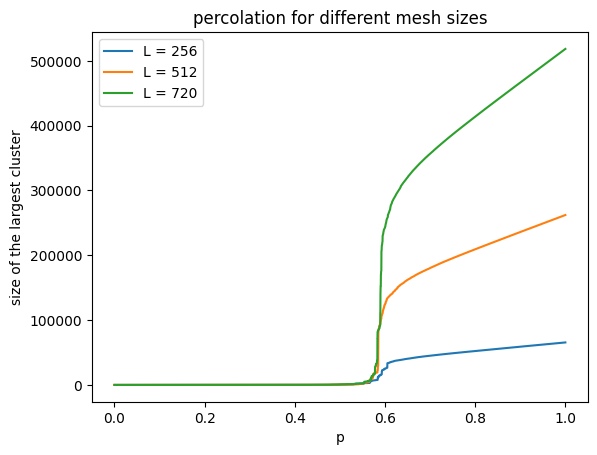

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class NewmanPercolation:
    def __init__(self, L):
        self.L = L
        self.N = L**2
        self.empty = -(self.N + 1)
        self.ptr = np.zeros(self.N, dtype=int)
        self.nn = np.zeros((self.N, 4), dtype=int)
        self.order = np.zeros(self.N, dtype=int)
        self.boundaries()

    def boundaries(self):
        for i in range(self.N):
            self.nn[i, 0] = (i + 1) % self.N
            self.nn[i, 1] = (i + self.N - 1) % self.N
            self.nn[i, 2] = (i + self.L) % self.N
            self.nn[i, 3] = (i + self.N - self.L) % self.N

            if i % self.L == 0:
                self.nn[i, 1] = i + self.L - 1
            if (i + 1) % self.L == 0:
                self.nn[i, 0] = i - self.L + 1

    def permutation(self):
        self.order = np.arange(self.N)
        np.random.shuffle(self.order)

    def findroot(self, i):
        if self.ptr[i] < 0:
            return i
        self.ptr[i] = self.findroot(self.ptr[i])
        return self.ptr[i]

    def union(self, r1, r2):
        if self.ptr[r1] > self.ptr[r2]:
            self.ptr[r2] += self.ptr[r1]
            self.ptr[r1] = r2
            return r2
        else:
            self.ptr[r1] += self.ptr[r2]
            self.ptr[r2] = r1
            return r1

    def percolate(self):
        X, Y = [], []
        big = 0
        for i in range(self.N):
            self.ptr[i] = self.empty
        for i in range(self.N):
            r1 = s1 = self.order[i]
            self.ptr[s1] = -1
            for j in range(4):
                s2 = self.nn[s1, j]
                if (self.ptr[s2] != self.empty):
                    r2 = self.findroot(s2)
                    if r2 != r1:
                        r1 = self.union(r1, r2)
                        if -self.ptr[r1] > big:
                            big = -self.ptr[r1]
            X.append((i + 1) / self.N)
            Y.append(big)
        return X, Y

def plot_percolation(L_values):
    plt.figure()

    for L in L_values:
        percolation = NewmanPercolation(L)
        percolation.permutation()
        X, Y = percolation.percolate()
        plt.plot(X, Y, '-', label=f'L = {L}')

    plt.xlabel("p")
    plt.ylabel("size of the largest cluster")
    plt.title("percolation for different mesh sizes")
    plt.legend()
    plt.show()

L_values = [256, 512, 720]
plot_percolation(L_values)
